In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from sklearn import metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer

reviews= []
rating = []
date = []
country = []


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways/'
pages = 37
page_size = 100

reviews = []

for i in range(1, pages+1):
    url = f'{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}'
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all('div', {'class': 'text_content'}):
        reviews.append(para.get_text())
    
print(f'   ---> {len(reviews)} total reviews')

   ---> 3616 total reviews


In [3]:
data = pd.DataFrame()
data['reviews'] = reviews
data

,reviews
0,✅ Trip Verified | I had the most fantastic BA...
1,✅ Trip Verified | Couldn’t book in online. Ar...
2,✅ Trip Verified | London Heathrow to Mumbai in...
3,"✅ Trip Verified | Keflavík, Iceland to London ..."
4,✅ Trip Verified | Terrible Experience with Bri...
...,...
3611,LHR-JFK-LAX-LHR. Check in was ok apart from be...
3612,LHR to HAM. Purser addresses all club passenge...
3613,My son who had worked for British Airways urge...
3614,London City-New York JFK via Shannon on A318 b...


In [4]:
data.to_csv('ba_reviews.csv')

In [5]:
reviews = pd.read_csv('ba_reviews.csv')
reviews = reviews.pop('reviews')
reviews

0       ✅ Trip Verified |  I had the most fantastic BA...
1       ✅ Trip Verified |  Couldn’t book in online. Ar...
2       ✅ Trip Verified | London Heathrow to Mumbai in...
3       ✅ Trip Verified | Keflavík, Iceland to London ...
4       ✅ Trip Verified | Terrible Experience with Bri...
                              ...                        
3611    LHR-JFK-LAX-LHR. Check in was ok apart from be...
3612    LHR to HAM. Purser addresses all club passenge...
3613    My son who had worked for British Airways urge...
3614    London City-New York JFK via Shannon on A318 b...
3615    SIN-LHR BA12 B747-436 First Class. Old aircraf...
Name: reviews, Length: 3616, dtype: object

In [6]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [7]:
reviews = reviews.str.replace('Trip Verified |', '')
reviews = reviews.str.replace('Verified', '')
reviews = reviews.str.replace('✅', '')
reviews = reviews.str.replace('|','')
reviews = reviews.str.replace(r'\b(\w{1,3})\b', '')
reviews = reviews.apply(remove_punctuations)
reviews

C:\Users\PC\AppData\Local\Temp/ipykernel_8736/2776793585.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews = reviews.str.replace('Trip Verified |', '')
C:\Users\PC\AppData\Local\Temp/ipykernel_8736/2776793585.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  reviews = reviews.str.replace('|','')
C:\Users\PC\AppData\Local\Temp/ipykernel_8736/2776793585.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews = reviews.str.replace(r'\b(\w{1,3})\b', '')


0             most fantastic  Flight today  cabin crew...
1          Couldn’ book  online Arrived  check   find ...
2         London Heathrow  Mumbai   Boeing   Business ...
3         Keflavík Iceland  London Heathrow   A320  Bu...
4         Terrible Experience with British Airways  bo...
                              ...                        
3611     Check    apart from being snapped   being  ea...
3612       Purser addresses  club passengers  name boa...
3613        worked  British Airways urged    British A...
3614    London City York   Shannon  A318   really nice...
3615     BA12 B747 First Class  aircraft 1998 with sea...
Name: reviews, Length: 3616, dtype: object

In [8]:
reviews.shape

(3616,)

In [9]:
words = pd.Series(' '. join(reviews).lower().split()).value_counts()[:30]
words

flight      6532
with        5791
were        4374
that        4285
this        3545
they        3528
have        3295
from        3044
very        2790
service     2758
seat        2340
food        2311
london      2143
crew        2110
british     2102
airways     2084
seats       2063
good        2037
time        2017
cabin       1934
which       1868
class       1830
there       1734
when        1543
staff       1540
business    1522
heathrow    1497
would       1480
only        1448
their       1414
dtype: int64

In [10]:
words_df = words.reset_index()
words_df.columns = ['word', 'frequency']

<AxesSubplot:xlabel='frequency', ylabel='word'>

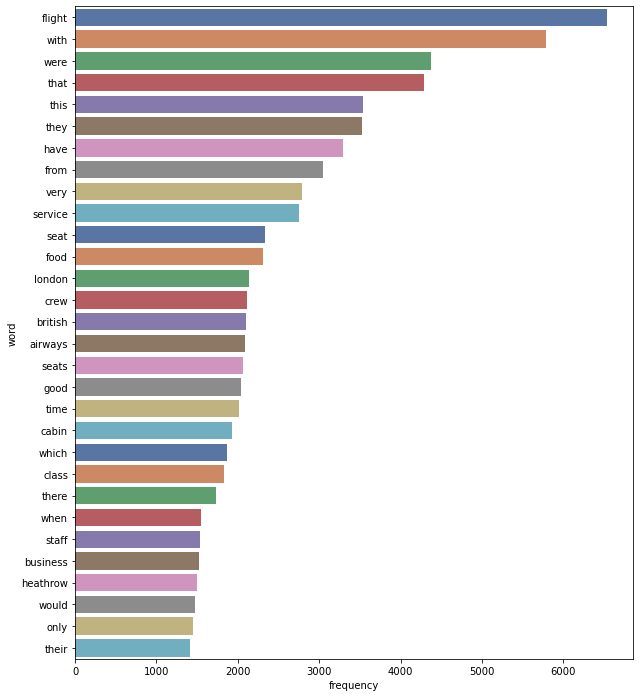

In [11]:
plt.figure(figsize=(10,12))
sns.barplot(data = words_df, y = 'word', x = 'frequency',orient='h', palette='deep')

In [12]:
rev = reviews.to_frame()

In [13]:
type(rev)

pandas.core.frame.DataFrame

In [14]:
rev.head()

,reviews
0,most fantastic Flight today cabin crew...
1,Couldn’ book online Arrived check find ...
2,London Heathrow Mumbai Boeing Business ...
3,Keflavík Iceland London Heathrow A320 Bu...
4,Terrible Experience with British Airways bo...


In [15]:
rev['reviews'].str.lower()

0             most fantastic  flight today  cabin crew...
1          couldn’ book  online arrived  check   find ...
2         london heathrow  mumbai   boeing   business ...
3         keflavík iceland  london heathrow   a320  bu...
4         terrible experience with british airways  bo...
                              ...                        
3611     check    apart from being snapped   being  ea...
3612       purser addresses  club passengers  name boa...
3613        worked  british airways urged    british a...
3614    london city york   shannon  a318   really nice...
3615     ba12 b747 first class  aircraft 1998 with sea...
Name: reviews, Length: 3616, dtype: object

In [16]:
rev['reviews'] = rev['reviews'].str.replace('\d+', '')

C:\Users\PC\AppData\Local\Temp/ipykernel_8736/3323889834.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  rev['reviews'] = rev['reviews'].str.replace('\d+', '')


In [17]:
rev.head

<bound method NDFrame.head of                                                 reviews
0           most fantastic  Flight today  cabin crew...
1        Couldn’ book  online Arrived  check   find ...
2       London Heathrow  Mumbai   Boeing   Business ...
3       Keflavík Iceland  London Heathrow   A  Busin...
4       Terrible Experience with British Airways  bo...
...                                                 ...
3611   Check    apart from being snapped   being  ea...
3612     Purser addresses  club passengers  name boa...
3613      worked  British Airways urged    British A...
3614  London City York   Shannon  A   really nice se...
3615   BA B First Class  aircraft  with seats that  ...

[3616 rows x 1 columns]>

In [18]:
stop = stopwords.words('english')

In [19]:
rev['reviews'] = rev['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [20]:
rev.head()

,reviews
0,fantastic Flight today cabin crew seat zone be...
1,Couldn’ book online Arrived check find bumped ...
2,London Heathrow Mumbai Boeing Business Class l...
3,Keflavík Iceland London Heathrow A Business Cl...
4,Terrible Experience British Airways booked fli...


In [21]:
words = pd.Series(' '. join(rev['reviews']).lower().split()).value_counts()[:30]
words

flight        6532
service       2758
seat          2340
food          2311
london        2143
crew          2110
british       2102
airways       2084
seats         2063
good          2037
time          2017
cabin         1934
class         1830
staff         1540
business      1522
heathrow      1497
would         1480
economy       1404
first         1254
check         1250
flights       1151
return        1095
club          1068
back          1047
hours         1023
plane         1017
lounge        1001
airline        993
passengers     991
boarding       981
dtype: int64

In [22]:
words_df = words.reset_index()
words_df.columns = ['word', 'frequency']

<AxesSubplot:xlabel='frequency', ylabel='word'>

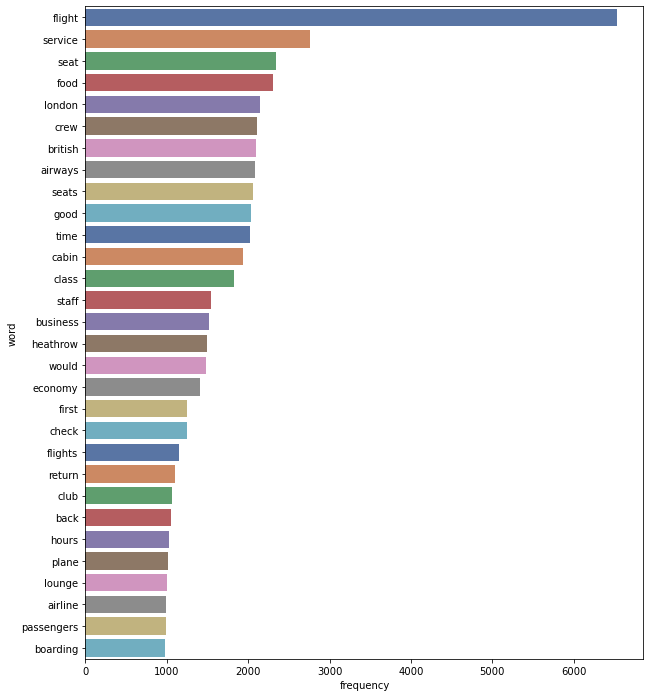

In [23]:
plt.figure(figsize=(10,12))
sns.barplot(data = words_df, y = 'word', x = 'frequency',orient='h', palette='deep')

In [24]:
sent = SentimentIntensityAnalyzer()

In [25]:
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in rev['reviews']]

In [26]:
rev['sentiment_score'] = polarity

In [27]:
rev.head

<bound method NDFrame.head of                                                 reviews  sentiment_score
0     fantastic Flight today cabin crew seat zone be...             0.99
1     Couldn’ book online Arrived check find bumped ...             0.71
2     London Heathrow Mumbai Boeing Business Class l...             0.98
3     Keflavík Iceland London Heathrow A Business Cl...             0.08
4     Terrible Experience British Airways booked fli...             0.63
...                                                 ...              ...
3611  Check apart snapped early check come back minu...             0.46
3612  Purser addresses club passengers name boarding...             0.77
3613  worked British Airways urged British Airways K...             0.70
3614  London City York Shannon A really nice seats p...             0.81
3615  BA B First Class aircraft seats private cabin ...             0.36

[3616 rows x 2 columns]>

In [28]:
pos_rev = rev[rev['sentiment_score'] > 0.9]
pos_rev

,reviews,sentiment_score
0,fantastic Flight today cabin crew seat zone be...,0.99
2,London Heathrow Mumbai Boeing Business Class l...,0.98
11,Fast friendly check total contrast Gatwick con...,0.98
12,understand British Airways classified star air...,0.92
15,Another really great pair flights time problem...,0.98
...,...,...
3596,Chicago Hare London Heathrow check fast effici...,0.94
3597,Travelled board A Boarding efficient dedicated...,0.97
3602,Club World Boeing Bought ticket managed last m...,0.97
3603,July flew overnight premium economy chose flig...,0.95


In [29]:
neg_rev = rev[rev['sentiment_score'] < 0.8]
neg_rev

,reviews,sentiment_score
1,Couldn’ book online Arrived check find bumped ...,0.71
3,Keflavík Iceland London Heathrow A Business Cl...,0.08
4,Terrible Experience British Airways booked fli...,0.63
5,airline lives past glory heading future crisis...,0.32
6,Check Desk rude dismissive Flight late seems n...,-0.53
...,...,...
3610,Just back Bridgetown Barbados flying British A...,-0.83
3611,Check apart snapped early check come back minu...,0.46
3612,Purser addresses club passengers name boarding...,0.77
3613,worked British Airways urged British Airways K...,0.70


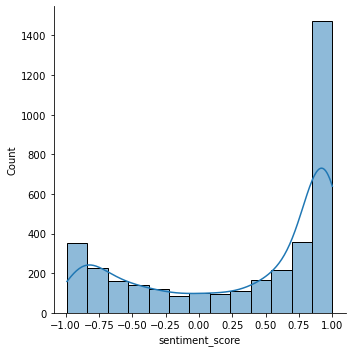

In [30]:
sns.displot(rev['sentiment_score'], kde=True, palette='deep')